In [1]:
"""
June 26, 2020

Looking at starting position of walkers.
"""


import ares
import numpy as np
import matplotlib.pyplot as pl
import distpy

In [2]:
data = ares.analysis.GalaxyPopulation() #for lit values

In [4]:
# Independent variables
# redshifts = np.array([0.35, 0.875, 1.125, 1.75, 2.25, 2.75])
redshifts = np.sort(np.array([0.35, 0.875, 1.125, 1.75, 2.25, 2.75, 1.65, 2.5, 3.5, 0.10165, 0.25, 0.45, 0.575, 0.725, 0.9]))

Ms = np.linspace(7, 12, 60)

# print(Ms)

# blob 1: the smf
blob_n1 = ['galaxy_smf']
blob_i1 = [('z', redshifts), ('bins', Ms)]
blob_f1 = ['StellarMassFunction']

In [5]:
blob_pars = \
{
 'blob_names': [blob_n1],
 'blob_ivars': [blob_i1],
 'blob_funcs': [blob_f1],
 'blob_kwargs': [None],
}

In [6]:
#define the parameters that remain unchanged
base_pars = ares.util.ParameterBundle('emma:model1')
base_pars.update(blob_pars)

# print(base_pars)
# This is important!
# base_pars['pop_calib_lum'] = None

In [12]:
free_pars = \
[
    'pq_func_par0[0]',
    'pq_func_par2[0]', 

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]',
]

is_log = [False, False, False, False, False, False, False, True]

from distpy.distribution import UniformDistribution
from distpy.distribution import DistributionSet

ps = DistributionSet()
ps.add_distribution(UniformDistribution(0, 4), 'pq_func_par0[0]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[0]')

ps.add_distribution(UniformDistribution(0, 2),   'pq_func_par0[1]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[1]')

ps.add_distribution(UniformDistribution(0, 1),   'pq_func_par0[2]')
ps.add_distribution(UniformDistribution(-3, 1),  'pq_func_par2[2]')

ps.add_distribution(UniformDistribution(10.0, 14.0),   'pq_func_par0[3]')
ps.add_distribution(UniformDistribution(-1, 2),  'pq_func_par2[3]')


In [13]:
#From Moster2010, table 7
logM_0 = 11.88 #(0.01)
mu = 0.019 #(0.002)
N_0 = 0.0282 #(0.0003)
nu = -0.72 #(0.06)
gamma_0 = 0.556 #0.001
gamma_1 = -0.26 #(0.05)
beta_0 = 1.06 #(0.06)
beta_1 = 0.17 #(0.12)

guesses = \
{
    'pq_func_par0[0]': beta_0,
    'pq_func_par2[0]': beta_1, 

    #norm
    'pq_func_par0[1]': N_0,
    'pq_func_par2[1]': nu, 

    #gamma
    'pq_func_par0[2]': gamma_0,
    'pq_func_par2[2]': gamma_1, 

    #peak mass
    'pq_func_par0[3]': logM_0,
    'pq_func_par2[3]': mu, 
}

# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.


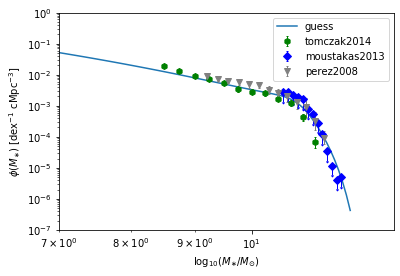

In [14]:
# base_pars
# Ms = np.logspace(7, 12, 60)

base_pars.update(guesses)
pop = ares.populations.GalaxyPopulation(**base_pars)

z = 1

smf = pop.StellarMassFunction(z, Ms)
pl.loglog(Ms, smf, label='guess')
data.PlotSMF(z=z, round_z=0.2, log10Mass=True)

pl.legend()
pl.show()

In [15]:
# Initialize a fitter object and give it the data to be fit
fitter_smf = ares.inference.FitGalaxyPopulation(**base_pars)

fitter_smf.include.append('smf')

# The data can also be provided more explicitly
#I seem to need this or else the run throws error: Must set data by hand! 
# fitter_lf.redshifts = {‘lf’: [5.9]}
fitter_smf.data = 'tomczak2014',  'mortlock2011', 'moustakas2013', 'marchesini2009_10'
#higher z
# fitter_smf.data = 'song2016', 'stefanon2017', 'duncan2014'

# print(fitter_smf.data)

In [16]:
fitter = ares.inference.ModelFit(**base_pars)
fitter.add_fitter(fitter_smf)

# Establish the object to which we'll pass parameters
from ares.populations.GalaxyHOD import GalaxyHOD
fitter.simulator = GalaxyHOD

In [17]:
# print(fitter.blob_names)
# print(fitter.blob_ivars)
# print(fitter.blob_funcs, fitter.blob_kwargs)


In [18]:
fitter.save_hmf = True  # cache HMF for a speed-up!
fitter.save_psm = True  # cache source SED model (e.g., BPASS, S99)

# Setting this flag to False will make ARES generate new files for each checkpoint.
fitter.checkpoint_append = False

fitter.parameters = free_pars
fitter.is_log = is_log
fitter.prior_set = ps

# In general, the more the merrier (~hundreds)
fitter.nwalkers = 30

fitter.jitter = [0.1] * len(fitter.parameters)
# fitter.jitter = [0.01, 0.01, 0.001, 0.005, 0.01, 0.01, 0.08, 0.01]
# fitter.jitter = [0.1, 0.1, 0.01, 0.05, 0.1, 0.1, 0.8, 0.1]

fitter.guesses = guesses
# fitter.debug('True')
# fitter.pops
# nwalkers

# Fixing position of walker 3 (parameter pq_func_par0[1])
# Moved from -0.07692615532542091 to 0.07913778887731368
# Fixing position of walker 7 (parameter pq_func_par0[1])
# Moved from -0.009236149975293203 to 0.24284857452847738
# Fixing position of walker 9 (parameter pq_func_par0[1])
# Moved from -0.08413775238134154 to 0.22017805777504984
# Fixing position of walker 10 (parameter pq_func_par0[1])
# Moved from -0.1658805172540207 to 0.023607498159466823
# Fixing position of walker 11 (parameter pq_func_par0[1])
# Moved from -0.06446054005003733 to 0.2040650033320639
# Fixing position of walker 20 (parameter pq_func_par0[1])
# Moved from -0.15646635617939125 to 0.12390593216762852
# Fixing position of walker 21 (parameter pq_func_par0[1])
# Moved from -0.05445764802286081 to 0.03234294031137815
# Fixing position of walker 22 (parameter pq_func_par0[1])
# Moved from -0.12137891849864169 to 0.12194648150959773
# Fixing position of walker 24 (parameter pq_func_par0[1])
# Moved from -0.

# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best

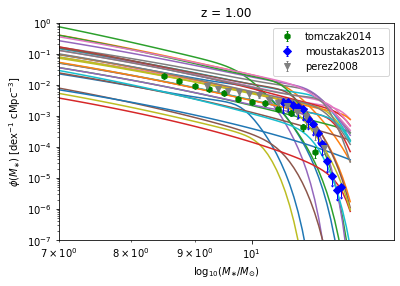

In [21]:
z = 1
# 2.5, 3.5

for w in fitter.guesses[:]:
#     print(w)
    
    pars_ch = {}
    for i in range(len(w)):
        pars_ch[free_pars[i]] = w[i]
        
    base_pars.update(pars_ch)
    pop = ares.populations.GalaxyPopulation(**base_pars)

    smf = pop.StellarMassFunction(z, Ms)
    pl.loglog(Ms, smf)#, label='guess')

data.PlotSMF(z=z, round_z=0.2, log10Mass=True)

pl.title("z = %.2f" %z)
pl.legend()
pl.show()
    

In [15]:
fitter.run('MCMC_files/test_smfcal_5', burn=5, steps=40, save_freq=4, clobber=True)

Saved HaloMassFunction instance to limit I/O.
# Starting burn-in: Tue Jun 30 15:43:06 2020
# Wrote MCMC_files/test_smfcal_5.burn.dd0000.facc.pkl: Tue Jun 30 15:56:11 2020
Writing data one last time because save_freq > steps.
# Wrote MCMC_files/test_smfcal_5.burn.dd0001.facc.pkl: Tue Jun 30 15:58:38 2020
# Burn-in complete in 931 seconds.
# Fixing position of walker 4 (parameter pq_func_par0[1])
# Moved from -0.018554054184946794 to 0.10147883243275771
# Fixing position of walker 12 (parameter pq_func_par0[1])
# Moved from -0.026726604033736237 to 0.061760079095139114
# Fixing position of walker 3 (parameter pq_func_par2[3])
# Moved from 0.1482926594689266 to 0.05282792790015336
# Fixing position of walker 6 (parameter pq_func_par2[3])
# Moved from 0.1292351782598517 to 0.0337856518421112
# Fixing position of walker 19 (parameter pq_func_par2[3])
# Moved from 0.12748836594930468 to 0.07318067025065922
# Fixing position of walker 22 (parameter pq_func_par2[3])
# Moved from 0.125904880819

In [16]:
anl = ares.analysis.ModelSet('MCMC_files/test_smfcal_5')
# anl = ares.analysis.ModelSet('MCMC_files/smf_run2')
# anl = ares.analysis.ModelSet('MCMC_files/smf_run5')


labels = \
{
    'pq_func_par0[0]': 'beta_0',
    'pq_func_par2[0]': 'beta_1', 

    #norm
    'pq_func_par0[1]': 'N_0',
    'pq_func_par2[1]': 'nu', 

    #gamma
    'pq_func_par0[2]': 'gamma_0',
    'pq_func_par2[2]': 'gamma_1', 

    #peak mass
    'pq_func_par0[3]': 'logM_0',
    'pq_func_par2[3]': 'mu', 
}

anl.custom_labels = labels

# anl.skip = 5000


##############################################################################################################
####                                         Analysis: Model Set                                          ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Basic Information                                                                                    ####
#### ---------------------------------------------------------------------------------------------------- ####
#### path        : MCMC_files/                                                                            ####
#### prefix      : test_smfcal_5                                                                          ####
#### N-d         : 8                                                                                      ####


# Loading MCMC_files/test_smfcal_5.dd*.chain.pkl...
# Loaded MCMC_files/test_smfcal_5.dd*.chain.pkl in 0.16 s.
# Loaded MCMC_files\test_smfcal_5.dd0000.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\test_smfcal_5.dd0001.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\test_smfcal_5.dd0002.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\test_smfcal_5.dd0003.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\test_smfcal_5.dd0004.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\test_smfcal_5.dd0005.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\test_smfcal_5.dd0006.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\test_smfcal_5.dd0007.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\test_smfcal_5.dd0008.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\test_smfcal_5.dd0009.blob_2d.galaxy_smf.pkl


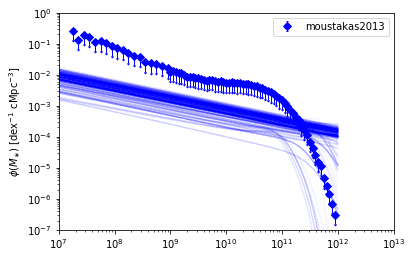

In [17]:
#look at the raw LF samples
# ax = anl.ReconstructedFunction('galaxy_lf', ivar=[6, None], samples='all', color='b', alpha=0.01)

# ax.set_yscale('log')
z = 0.
# 0.35, 0.875, 1.125, 1.75, 2.25, 2.75

gpop = ares.analysis.GalaxyPopulation()

ax = anl.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)

# Plot any data within dz=0.1 of z=6
gpop.PlotSMF(z, ax=ax, round_z=0.2, log10Mass=True)

# ax.set_ylim(1e-35, 1)
# ax.set_xlim(1e7, 1e13)

ax.legend()
pl.show()

# ax = anl_2.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)
# gpop.PlotSMF(z, ax=ax, round_z=0.2)

In [19]:
params = \
['pq_func_par0[0]',
    'pq_func_par2[0]', 

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]' 
]

covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))

pq_func_par0[0]: 1.375220e+00
pq_func_par2[0]: 6.085517e-01
pq_func_par0[1]: 9.574037e-02
pq_func_par2[1]: -8.723569e-01
pq_func_par0[2]: 6.282633e-01
pq_func_par2[2]: -6.267905e-01
pq_func_par0[3]: 1.206064e+01
pq_func_par2[3]: 7.303318e-02


0 of 1200 chain elements ignored because of chain links with inf's/nan's.


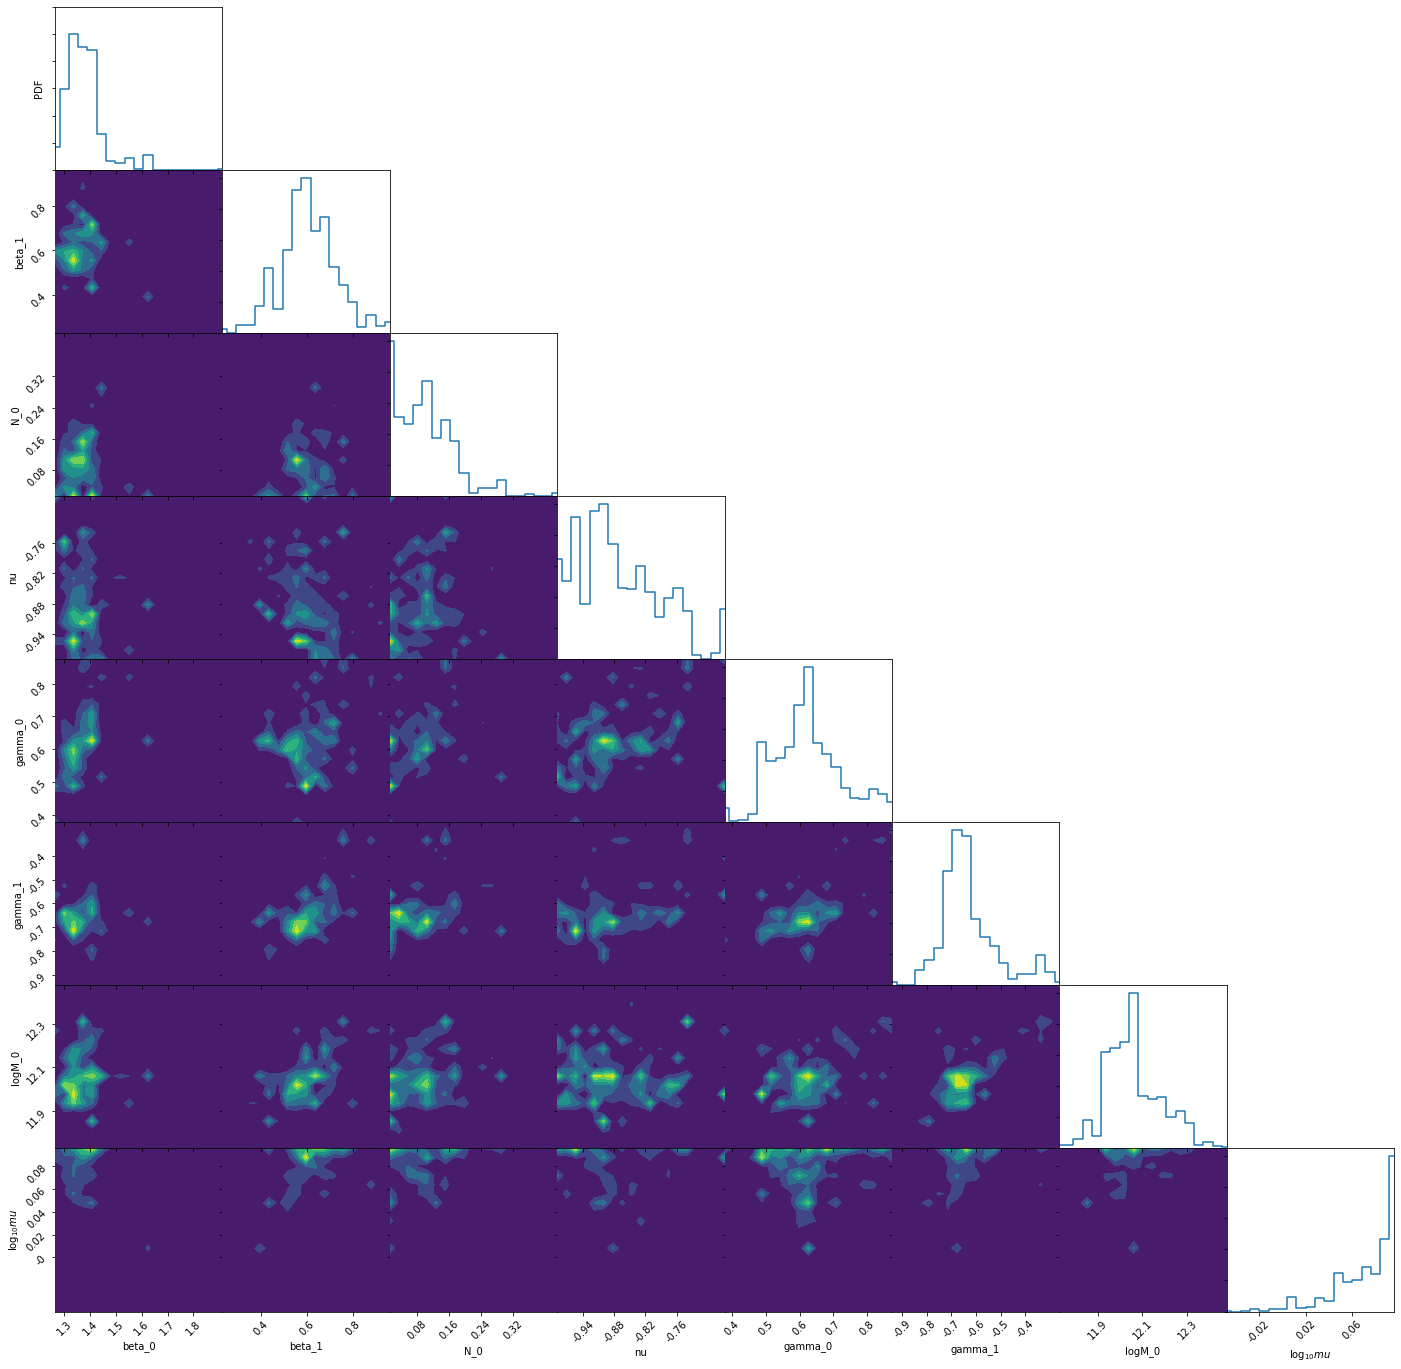

In [20]:

trig = anl.TrianglePlot(pars=params)

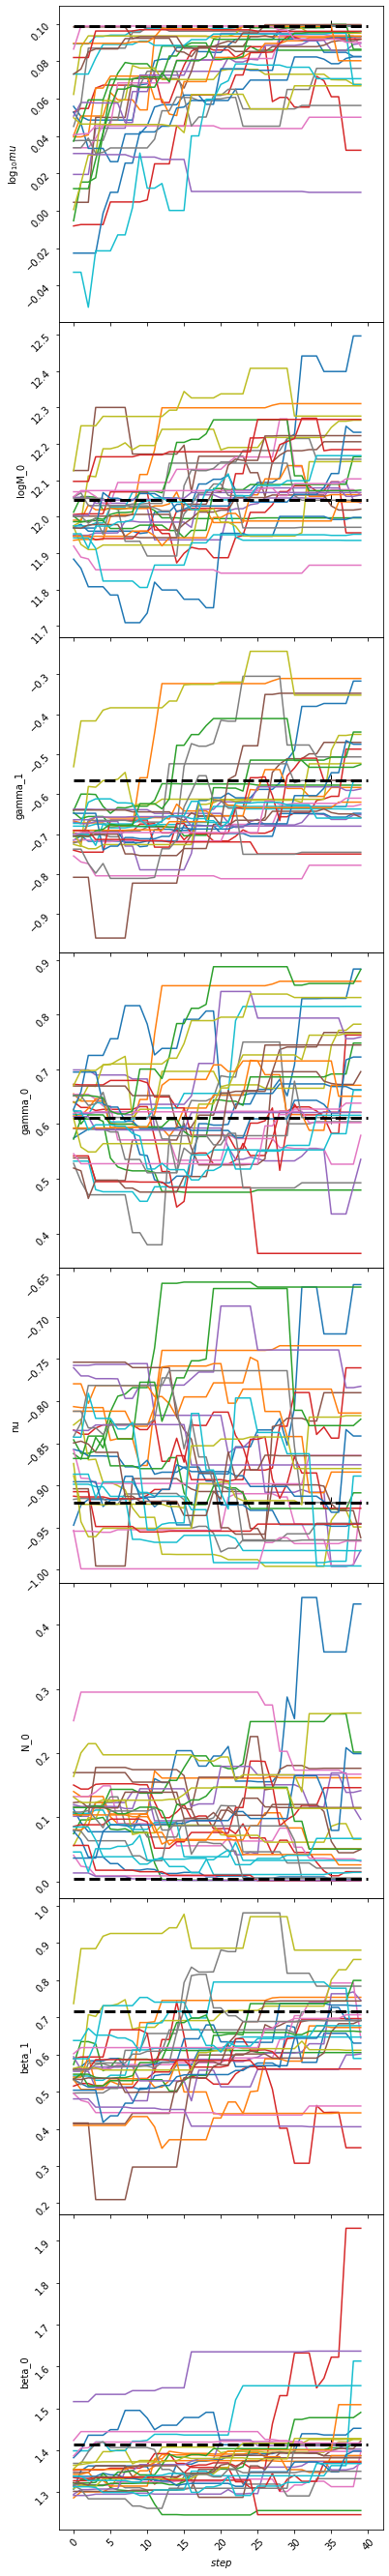

In [21]:
anl.WalkerTrajectoriesMultiPlot(best_fit='mode')
# mode: 2190
# median: -3171602.2183875367

In [157]:
anl.max_likelihood_parameters()

{'pq_func_par0[0]': 1.5905553913322652,
 'pq_func_par2[0]': 0.31970042658892567,
 'pq_func_par0[1]': 1.1784112232748996,
 'pq_func_par2[1]': 0.24184601818185716,
 'pq_func_par0[2]': 0.2502845706775371,
 'pq_func_par2[2]': -0.3830087324154898,
 'pq_func_par0[3]': 13.75563085550371,
 'pq_func_par2[3]': 1.361815786126633}

In [158]:
covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))
        
fit_mean = np.array(covar[0])

pq_func_par0[0]: 1.796118e+00
pq_func_par2[0]: 2.698563e-01
pq_func_par0[1]: 2.373391e-01
pq_func_par2[1]: -1.592191e-01
pq_func_par0[2]: 5.568722e-01
pq_func_par2[2]: -5.518262e-01
pq_func_par0[3]: 1.149333e+01
pq_func_par2[3]: 1.113339e+00


In [159]:
pars_ch = {}
for i in range(len(covar[0])):
    pars_ch[params[i]] = covar[0][i]
    
pars_mean = ares.util.ParameterBundle("emma:model1")

pars_mean.update(pars_ch)
# print(pars_best)
pop_mean = ares.populations.GalaxyPopulation(**pars_mean)

In [160]:
fit_best_like = anl.max_likelihood_parameters()

for i in range(len(covar[0])):
    print(anl.get_1d_error(params[i])) #(maximum likelihood value, positive error, negative error).

(1.5905553913322652, array([0.6327728 , 0.20049189]))
(0.31970042658892567, array([0.19000562, 0.33407553]))
(1.1784112232748996, array([-0.69417021,  1.16529621]))
(0.24184601818185716, array([0.05914661, 0.82205954]))
(0.2502845706775371, array([ 0.5770657 , -0.02249631]))
(-0.3830087324154898, array([0.20526424, 0.55360017]))
(13.75563085550371, array([-1.80013134,  2.64011916]))
(1.361815786126633, array([0.29920769, 0.89725306]))


In [161]:
pars_best = ares.util.ParameterBundle("emma:model1")

print(fit_best_like)

pars_best.update(fit_best_like)
# print(pars_best)
pop_best = ares.populations.GalaxyPopulation(**pars_best)

{'pq_func_par0[0]': 1.5905553913322652, 'pq_func_par2[0]': 0.31970042658892567, 'pq_func_par0[1]': 1.1784112232748996, 'pq_func_par2[1]': 0.24184601818185716, 'pq_func_par0[2]': 0.2502845706775371, 'pq_func_par2[2]': -0.3830087324154898, 'pq_func_par0[3]': 13.75563085550371, 'pq_func_par2[3]': 1.361815786126633}


# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.


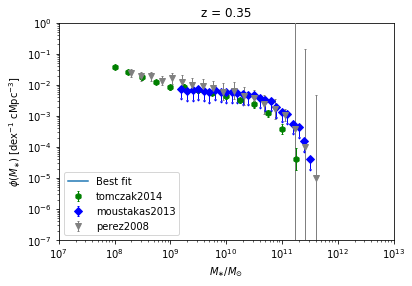

In [162]:
z = 0

Ms_short = np.linspace(7, 13, 80)
# Ms_short = [1e9]

# print(Ms)

ls_best = pop_best.StellarMassFunction(z, Ms_short)
# ls_best_2 = pop_best_2.StellarMassFunction(z, Ms_short)

# print(ls_best)

ls_mean = pop_mean.StellarMassFunction(z, Ms_short)

obslf = ares.analysis.GalaxyPopulation()
obslf.PlotSMF(z=z, round_z=0.2, log10Mass=True)

pl.semilogy(Ms_short, ls_best, label='Best fit')
# pl.loglog(Ms_short, ls_best_2, label='Best fit 2')

# pl.loglog(Ms_short, ls_mean, label='Mean fit')
pl.title("z = %.2f" %z)
pl.legend()
# pl.ylim(1e-15, 1e2)
pl.show()

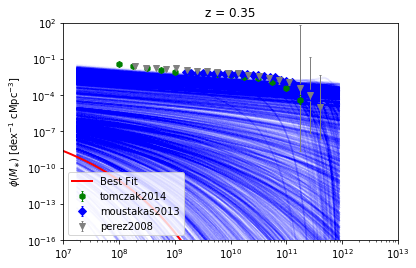

In [169]:
z = .35

# print(Ms)

ls_best = pop_best.StellarMassFunction(z, Ms_short)
ax = anl.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)

# ax = anl.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples=100, color='orange', alpha=0.5, ls="--")

# print(ls_best)

obslf = ares.analysis.GalaxyPopulation()
obslf.PlotSMF(z=z, ax=ax, round_z=0.2, log10Mass=True)

ax.semiplogy(Ms_short, ls_best, label='Best Fit', color="red", linewidth=2)

pl.title("z = %.2f" %z)
pl.legend()
pl.ylim(1e-16, 1e2)
pl.show()


In [116]:
bests = [anl.get_1d_error(i, nu=0.68,  peak='mode') for i in params]

pars = ares.util.ParameterBundle("emma:model1")


In [117]:
print(bests)
print()
print(fit_mean)

[(1.5905553913322652, array([0.63705268, 0.199072  ])), (0.31970042658892567, array([0.19041404, 0.33495609])), (1.1784112232748996, array([-0.69309964,  1.16526477])), (0.24184601818185716, array([0.05933723, 0.82186028])), (0.2502845706775371, array([ 0.57534054, -0.02238445])), (-0.3830087324154898, array([0.20611646, 0.55513616])), (13.75563085550371, array([-1.79837454,  2.64036601])), (1.361815786126633, array([0.30235878, 0.89291749]))]

[ 1.79820826  0.26920532  0.2382419  -0.15734286  0.5556781  -0.55301121
 11.49456221  1.11667607]


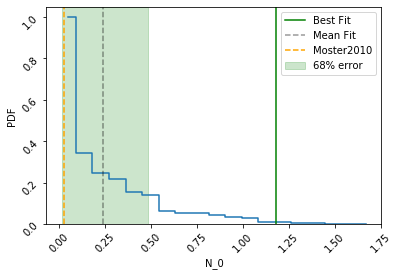

In [118]:
i = 2

ax = anl.PosteriorPDF(pars=params[i])

pl.axvline(x=bests[i][0], ls="-", color="green", label="Best Fit")

ax.axvspan(bests[i][0]-bests[i][1][1], bests[i][0]+bests[i][1][0], alpha=0.2, color='green' ,label="68% error")

pl.axvline(x=fit_mean[i], ls="--", color="black", label="Mean Fit",  alpha=0.4)

pl.axvline(x=pars[params[i]], ls="--", color="orange", label="Moster2010",  alpha=1)

pl.legend()
pl.show()